# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [63]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [64]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data['income'].value_counts()['>50K']

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data['income'].value_counts()['<=50K']

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round(data['income'].value_counts()['>50K']/data['income'].value_counts().sum()*100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


**Hint**: It is apparent that the class of the labels, i.e. income, is imbalanced which should be accounted for in sampling!

**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

/Users/romanwolf/Code/Finding Donors Project/visuals.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


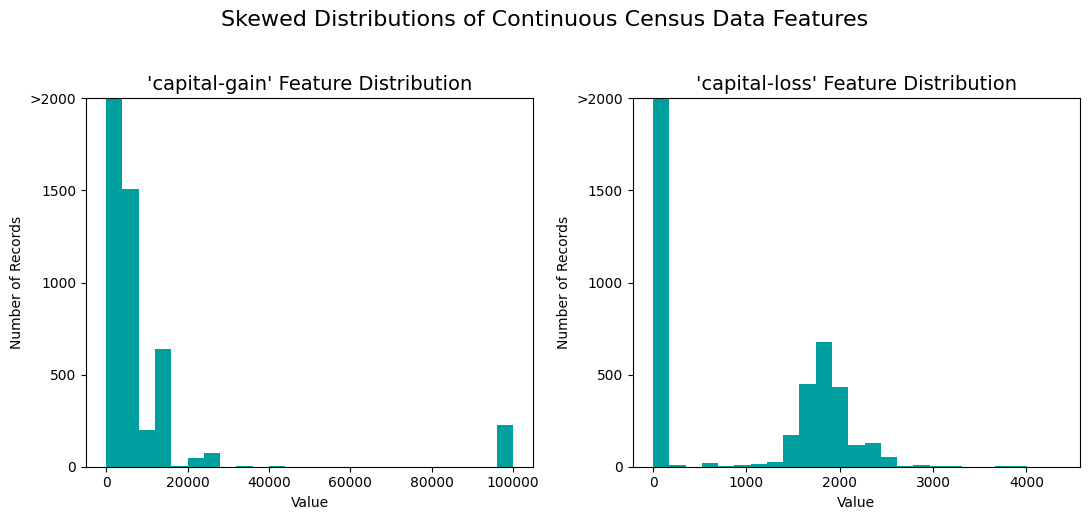

In [65]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

/Users/romanwolf/Code/Finding Donors Project/visuals.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


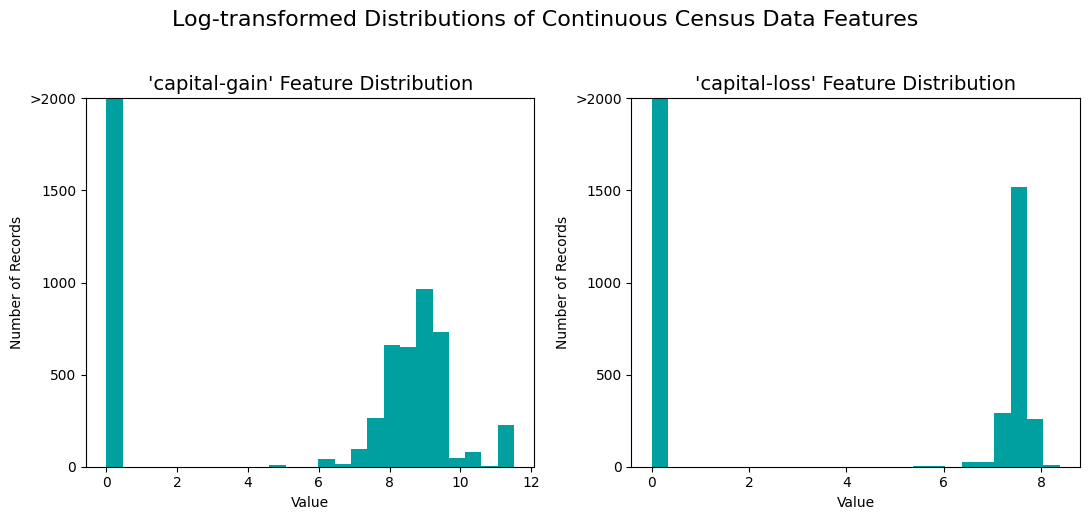

In [66]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [67]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [68]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = (income_raw == ">50K").astype(np.uint8)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [69]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final,
                                                    income,
                                                    stratify = income, # to account for imbalanced income
                                                    test_size = 0.2,
                                                    random_state=42) # to introduce randomness

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{( \beta^2 \cdot precision) + recall}$$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \\$50,000 and those who make more), it's clear most individuals do not make more than \\$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \\$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \\$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives (words classified as spam, and which are actually spam) to all positives (all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positive (words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spa (including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam (all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than \\$50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT**: 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negative (TN) or False Negative (FN) as we are not making any negativ ('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precisio (True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall scor (True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [70]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.

FP = income.count() - TP # Specific to the naive case
FP = np.sum(np.logical_and(preds == 1, actual == 0))

TN = 0 # No predicted negatives in the naive case


FN = 0 # No predicted negatives in the naive case
FN = np.sum(np.logical_and(preds == 0, actual == 1))
'''
# TODO: Calculate accuracy, precision and recall
preds = np.ones_like(income) # since predictions are always 1
actual = np.array(income) # actual/true incom

TP = np.sum(np.logical_and(preds == 1, actual == 1))
FN = np.sum(np.logical_and(preds == 0, actual == 1))
FP = np.sum(np.logical_and(preds == 1, actual == 0))

accuracy = np.sum(preds == actual)/len(actual)
recall = TP / (TP + FN)
precision = TP/(TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta**2)*(precision*recall)/(beta**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**HINT**: Structure your answer in the same format as above, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer**:

## 1. Gaussian Naive Bayes (NB)
### 1.1 Description of one real-world application of NB
Gaussian Naive Bayes can be trained to map lesion-symptoms on a dataset of labeled brain images (MRI scans) based on the presence of stroke lesions. First, brain images are preprocessed to extract relevant features such as measurements of the intensity or texture of specific regions of the brain. Next, the algorithm is trained on a labeled dataset using Bayes' theorem to compute the probability that a given set of features belongs to the "normal" or "abnormal" class. When a new, unlabeled brain image is presented to the algorithm, it computes the probability that the image belongs to each class based on the extracted features. The class with the highest probability is then assigned to the image, indicating whether or not stroke lesions are present (https://www.sciencedirect.com/science/article/abs/pii/S0165027015003520).

### 1.2 Strengths of NB
* Naive-Bayes classifiers are very simple and easy to understand. The induction of these classifiers is extremely fast, requiring only a single pass through the data if all attributes are discrete (https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf).
* Efficiency: Naive Bayes can be trained quickly and requires relatively little memory to store the model, making it suitable for large datasets (https://link.springer.com/article/10.1023/A:1007413511361).
* Scalability: Naive Bayes works well with large datasets and high-dimensional feature space. 
* High accuracy: Despite its simplicity, Naive Bayes has been shown to be highly effective in many applications, especially when the assumption of independence between the features holds true.

### 1.3 Weaknesses of NB
* Naive Bayes' conditional independence assumption is rarely true in real-world applications. Nonetheless, it produces supprisingly good results in classifications (https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf).
* Sensitivity to feature selection: Naive Bayes performs well when the most relevant features are selected, but it can be sensitive to irrelevant features. If irrelevant features are included in the model, they can lead to overfitting and decreased accuracy (https://www.cc.gatech.edu/fac/Charles.Isbell/classes/reading/papers/Rish.pdf).
* Continuous features: The categorical Naive Bayes classifier is suitable for classifications with discrete features that are categorically distributed which means it may not work well with continuous features or features with a large number of unique values (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html)
* Imbalanced data: Naive Bayes assumes that the class distribution in the training data is balanced, which means it may not work well with imbalanced data where one class is significantly more prevalent than the others.

### 1.4 Why is NB a good candidate?
Naive Bayes works well with categorical data, such as the demographic variables found in census data. It can handle multiple categorical variables and their combinations effectively. Moreover, it is quick and efficient and performed well on previous tasks. 

## 2. K-Nearest Neighbours (KNN)
### 2.1 Description of one real-world application of KNN
**Prediction of heart disease** (https://link.springer.com/article/10.1007/s42979-020-00365-y): KNN is used to detect the risk of heart disease by looking at a person's medical information such as age, blood pressure, and cholesterol level. The algorithm compares this information to information from other people who have been diagnosed with or without heart disease to determine the probability that the person being evaluated may have the condition.

It works by finding the K number of people in the dataset who have medical information that is most similar to the person being evaluated. These similar people are known as the K-nearest neighbors. The algorithm then looks at the diagnoses of the K-nearest neighbors and assigns a probability to the person being evaluated based on the number of neighbors with or without heart disease.

For example, if the KNN algorithm finds that the 5 nearest neighbors of a person being evaluated had heart disease, then it would predict that the person being evaluated may have a higher risk of heart disease than someone whose 5 nearest neighbors did not have heart disease.

Overall, the KNN algorithm is a useful tool for doctors and medical professionals to help them identify people who may be at risk of heart disease so that they can take appropriate preventative measures.


### 2.2 Strengths of KNN
1. Non-parametric: KNN algorithm is a non-parametric algorithm which is suitable for a wide range of data types and structures.
3. Flexibility: KNN can be used for classification and regression tasks.
4. No training required: KNN algorithm doesn't require a separate training phase, as it stores all the available data points in memory and learns from them during the prediction phase.
5. High accuracy: for datasets with clear boundaries between classes
6. Robust to noisy data: KNN doesn't make any assumptions about the underlying distribution of the data, and can still classify data points correctly even if some of the data points are noisy.
7. Easily adaptable to new data: KNN algorithm can easily adapt to new data by simply adding new data points to the existing dataset, making it a useful algorithm for real-time applications where new data is constantly being generated.

https://hastie.su.domains/Papers/ESLII.pdf, https://towardsdatascience.com/k-nearest-neighbours-explained-7c49853633b6

### 2.3 Weaknesses of KNN
1. Computational complexity: KNN algorithm can be computationally expensive, especially for large datasets, because it needs to calculate the distances between the new data point and all the existing data points in the dataset.
2. High memory usage: As a result of the missing training phase all the training data points are stored in memory, which can be a problem for datasets with a large number of features or a large number of data points.
3. Sensitive to irrelevant features: KNN algorithm is sensitive to irrelevant features in the dataset, which can affect the accuracy of the algorithm. (https://www.jmlr.org/papers/volume3/forman03a/forman03a_full.pdf)
4. Sensitivity to the choice of K: A small value of K may result in overfitting, while a large value of K may result in underfitting.
5. Imbalanced data: KNN algorithm can be biased towards the majority class in datasets with imbalanced data, where one class is much more prevalent than the other. (https://www.researchgate.net/publication/220520041_A_Study_of_the_Behavior_of_Several_Methods_for_Balancing_machine_Learning_Training_Data)
6. Distance metric selection: The performance of KNN algorithm is dependent on the choice of distance metric, which can be a problem when dealing with datasets with high dimensional or non-Euclidean data. (https://link.springer.com/chapter/10.1007/3-540-44503-x_27)

### 2.4 Why is KNN a good candidate?
KNN could be a good candidate for the donor problem since it is a non-parametric algorithm that is particularly effective in handling high-dimensional data with complex relationships between variables. In the context of finding donors, a census dataset may contain a large number of variables, such as demographic information, income, and education, which can make it challenging to identify patterns and relationships between variables.

## 3. Gradient Boosting
### 3.1 Description of one real-world application of gradient boosting
Gradient boosting is used to model credit riks which refers to assessing the creditworthiness of individuals or businesses seeking credit for example based on historical data that is used to identify which applicants are more likely to default on their loans. Factors that contribute to credit risk are for example income, employment history, and credit score. By combining these factors into a single model banks can make more informed decisions about whether to approve or reject loan applications, and what interest rates to offer to approved applicants. https://www.sciencedirect.com/science/article/abs/pii/S1568494618305465

### 3.2 Strengths of gradient boosting
* High predictive accuracy: Gradient Boosting is known for its high accuracy and ability to achieve state-of-the-art results on a variety of predictive modeling tasks. (https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full)
* Flexibility: Gradient Boosting can be applied to a wide range of data types and is capable of handling both numeric and categorical data, as well as missing values. (https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full)
* Robustness: Gradient Boosting is less sensitive to outliers and noise in the data compared to other machine learning algorithms, such as neural networks. (https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full)
* Ensemble method: Gradient Boosting is an ensemble method that combines the results of multiple weak models to produce a strong final model, making it more resilient to overfitting and generalizing better on unseen data.

### 3.3 Weaknesses of gradient boosting
* Computationally expensive: Gradient Boosting can be computationally expensive and requires a lot of computational resources, especially when dealing with large datasets or complex models. (https://arxiv.org/abs/1603.02754)
* Prone to overfitting: Gradient Boosting can be prone to overfitting, especially if the model is too complex or if the data is noisy. This can be mitigated by tuning the hyperparameters or by using regularization techniques.
* Sensitive to hyperparameters: Gradient Boosting has several hyperparameters that need to be tuned to achieve optimal performance, and different datasets may require different sets of hyperparameters. This can be time-consuming and requires some knowledge and experience to do effectively.
* Limited interpretability: Although Gradient Boosting provides information on feature importance, the model itself can be difficult to interpret and understand, especially when dealing with complex models.
* Requires clean data: Gradient Boosting performs best with clean data, and may struggle with missing or inconsistent data. Preprocessing and feature engineering may be required to ensure that the data is suitable for Gradient Boosting.

### 3.4 Why is gradient boosting a good candidate?
Its high predictive accuracy makes gradient boosting a good candidate to find donors. In addition, its ensemble approach can very useful with census dataset as it allows the model to capture and learn from the interaction between the different features. Moreover, gradient boosting is scalable and can handle large datasets.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [71]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])    
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]           
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
###########################################################################################
    
    # TODO: Compute precision on training set using precision_score()
    results['prec_train'] = precision_score(y_train[:300], predictions_train[:300])
    
    # TODO: Compute precision on test set using precision_score()
    results['prec_test'] = precision_score(y_test, predictions_test)
    
    # TODO: Compute accuracy on training set using recall_score()
    results['recall_train'] = recall_score(y_train[:300], predictions_train[:300])
    
    # TODO: Compute accuracy on test set using recall_score()
    results['recall_test'] = recall_score(y_test, predictions_test)    
    
###########################################################################################    
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


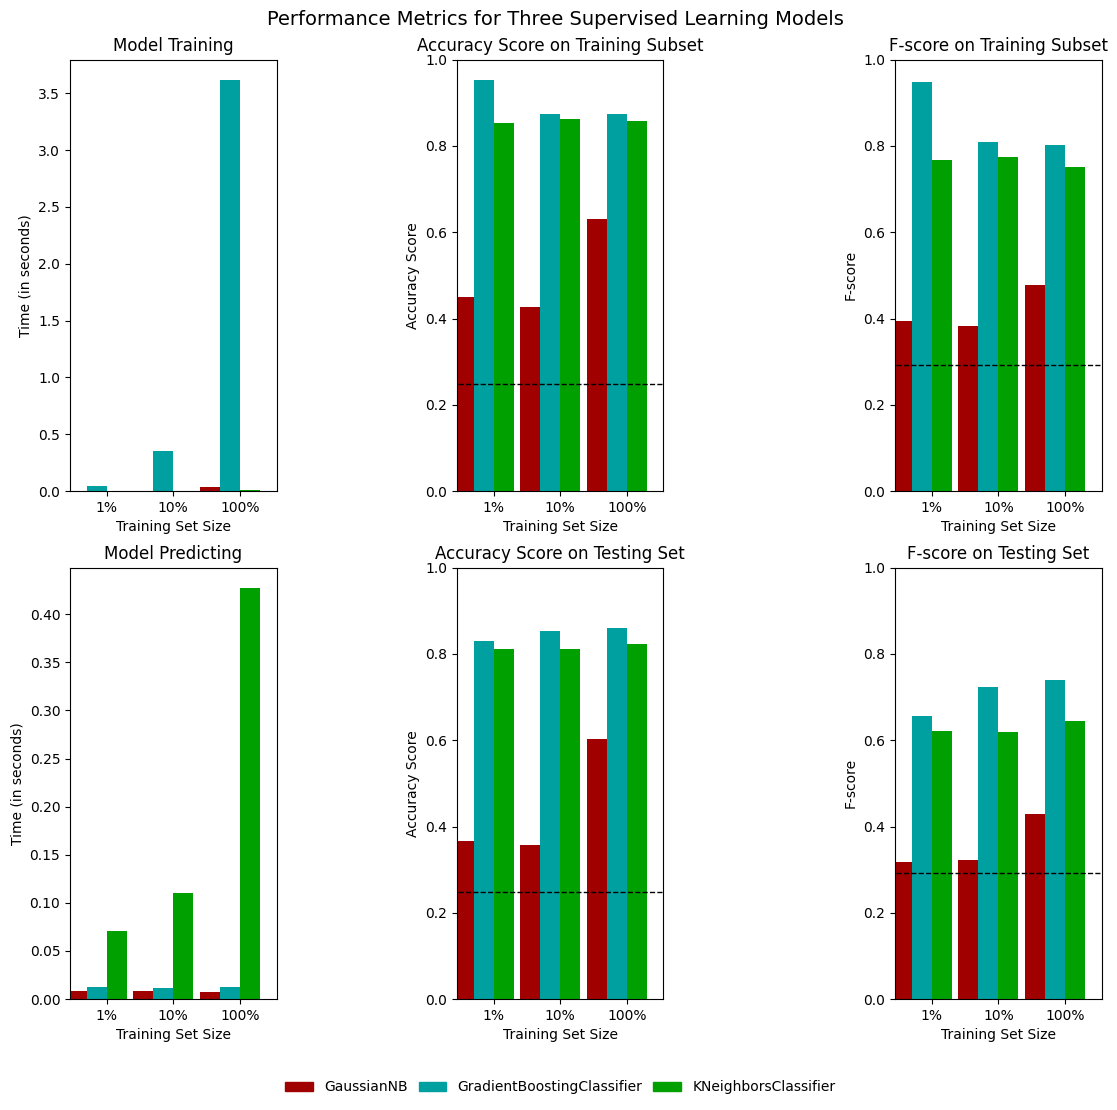

In [72]:
'''
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression
'''

# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

list_models = [GaussianNB(), # no random_state can be introduced to GaussianNB
               GradientBoostingClassifier(random_state=33),
               KNeighborsClassifier()] # no random_state can be introduced to KNN 

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
results_df = pd.DataFrame(columns=['Model', 'Sample Size',
                                   'Time Training', 'Time Prediction',                                  
                                   'Accuracy Training', 'Accuracy Test',
                                   'Precision Training', 'Precision Test',
                                   'Recall Training', 'Recall Test',
                                   'F-Score Training', 'F-Score Test'])

# for clf in [clf_A, clf_B, clf_C]:    
for clf in list_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train.values.ravel(), X_test, y_test)
        
        df = pd.DataFrame({'Model': [clf_name],
                           'Sample Size': [samples],
                           'Time Training': [results[clf_name][i]['train_time']],
                           'Time Prediction': [results[clf_name][i]['pred_time']],
                           'Accuracy Training': [results[clf_name][i]['acc_train']],
                           'Accuracy Test': [results[clf_name][i]['acc_test']],
                           'Precision Training': [results[clf_name][i]['prec_train']],
                           'Precision Test': [results[clf_name][i]['prec_test']],
                           'Recall Training': [results[clf_name][i]['recall_train']],
                           'Recall Test': [results[clf_name][i]['recall_test']],
                           'F-Score Training': [results[clf_name][i]['f_train']],
                           'F-Score Test': [results[clf_name][i]['f_test']]})
        
        results_df = pd.concat([results_df, df], ignore_index=True)
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [73]:
results_df.sort_values(by='F-Score Test', ascending=False).head()

,Model,Sample Size,Time Training,Time Prediction,Accuracy Training,Accuracy Test,Precision Training,Precision Test,Recall Training,Recall Test,F-Score Training,F-Score Test
5,GradientBoostingClassifier,36177,3.615034,0.012363,0.873333,0.860254,0.833333,0.787647,0.697674,0.597235,0.802139,0.740434
4,GradientBoostingClassifier,3617,0.356856,0.011775,0.873333,0.853621,0.852941,0.772565,0.674419,0.580285,0.810056,0.724549
3,GradientBoostingClassifier,361,0.048633,0.012280,0.953333,0.828966,0.973684,0.669264,0.860465,0.612846,0.948718,0.657165
8,KNeighborsClassifier,36177,0.010204,0.426949,0.856667,0.823328,0.752941,0.661323,0.744186,0.588760,0.751174,0.645414
6,KNeighborsClassifier,361,0.000888,0.071260,0.853333,0.812383,0.808824,0.657061,0.639535,0.508475,0.768156,0.620780


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \\$50,000. 

**HINT**: 
Look at the graph at the bottom left from the cell above, i.e. the visualization created by `vs.evaluate(results, accuracy, fscore)` and check the F-score for the testing set when 100\% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F-score on the testing when 100\% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer**:
* Given the visualized results, the Gradient Boosting Classifier performs best for the data among the tested algorithms. Even though training takes quite a while (3.6 s with the complete training set), prediction is relatively fast and using the entire dataset the algorithm achieves the comparatively highest accuracy and f-scores. Interestingly, this is also the case when using only 1\% or 10\% of the data.
* Using the complete dataset Gradient Boosting achieves a f-score of 0.802139 for beta = 0.5 with an accuracy of 0.860254.
* The training times for gradient boosting are the highest but model prediction is relatively fast, i.e. once the model is trained it predicts quickly.
* Given the previously discussed strenghts and weaknesses of test algorithms and the applied metrics for training and prediction, gradient boosting is best-suited amongst the 3 tested algorithms to find donors for *CharityML*.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**HINT**: When explaining your model, if using external resources please include all citations.

**Answer**: 
Gradient boosting is a machine learning algorithm that can be used to predict outcomes based on data. In the case of finding donors from census data, Gradient Boosting can help identify individuals who are more likely to donate based on certain characteristics such as age, income, occupation, and education level.

To train the overall model 80\% of the data is used, so-called training data. The remaining 20\% of the data, namely testing data, are used to evaluate the performance of the machine learning algorithm using metrics such as accuracy. When dividing the original dataset it is shuffled and it is also accounted for the imbalance of income between people that earn more than \\$50,000 (24.78\%) and those that earn less or equal \\$50,000 (75.22\%) which prevents effects on the training of the algorithm.

The algorithm works by building a model that predicts the probability of a person donating based on these characteristics. It does this by starting with a simple model that may not be very accurate, but is easy to compute. This simple model is called weak learner, which is a model that performs slightly better than random guessing, i.e. has an accuracy over 50\%, but is still not very accurate on its own. In the next step, the gradient boosting algorithm creates a new model that corrects the residual errors of the first model, i.e. the first weak learner. This process is repeated many times until the algorithm is able to create a complex model that accurately predicts the probability of a person donating based on their characteristics. 

Once the model is built, it can be used to identify individuals who are more likely to donate based on their characteristics. For example, the model might identify that individuals who are older, have higher incomes, and are more educated are more likely to donate. By using this information *CharityML* can target their fundraising efforts towards individuals who are more likely to donate, increasing the chances of raising the necessary funds.

GeÌron, A. (2019). *Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems* ($2^{nd}$ ed.). O’Reilly. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [74]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=33)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)
#grid_fit = grid_obj.fit(X_train_grid_fit, y_train_grid_fit.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8603
F-score on testing data: 0.7404

Optimized Model
------
Final accuracy score on the testing data: 0.8643
Final F-score on the testing data: 0.7418


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8603            | 0.8643          |
| F-score        | 0.7404            | 0.7418          |

**Answer:**
As can been seen from the data above, optimisation trough GridSearch brought slight improvement in accuracy (0.46\%) and F-score (0.19\%). However, compared to the naive predictor benchmarks with an accuracy of 0.2478 and a F-score of 0.2917, a significant improvement is achieved through the application of gradient boosting.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
1. Age: work experience which comes also with age is paid better than little or no experience.

2. Hours per week: people that work more get paid more for the same job.

3. Education level: the higher the education level, the higher the salary.

4. Sex: there is an evident gender pay gap between men and women. Clearly, the data doesn't take further sexes into consideration.

5. Occupation: different jobs get paid differently, e.g. gastronomy compared to banking.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

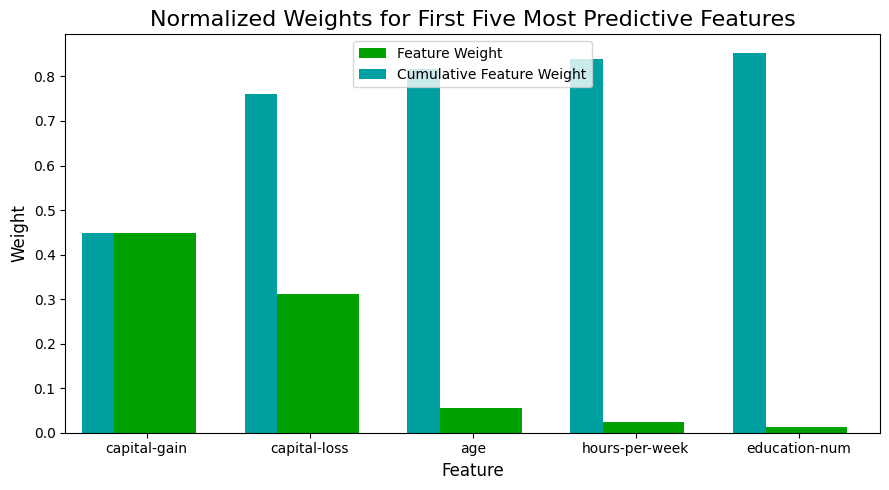

In [75]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=33,n_estimators=500).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
Age, hours per week and education were expected to have a stronger impact on income. However, their respective order was assumed correctly. Capital gain and loss were not considered before but have the highest impact on income. This could be due to the fact, that there is no clear understanding of what both terms might entail and in consequence both features were underestimated. In other words: misguessing the importance of capital gain and loss highlights the significance of a deeper understanding of a complete dataset of a project, i.e. every feature.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [76]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8643
F-score on testing data: 0.7418

Final Model trained on reduced data
------
Accuracy on testing data: 0.8371
F-score on testing data: 0.6919


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
The above numbers indicate that using only five criteria to train the model results in lower accuracy (0.8371) and f-score (0.6919). Nonetheless, selecting fewer features or using methods to keep only a certain amount of information, e.g. through PCA can be very useful when using more complex models since such approaches reduce computation time and thus are less time and resource consuming.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.